# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

We'll try to write some TensorFlow code to predict the price of Bitcoin based on the historical data of the Bitcoin itself.

## Get data
We're going to be using historical price data of BTC. Data has been downloaded from Yahoo Finance service.

In [1]:
# Import data with pandas
import pandas as pd

# Read in BTC data and pass the dates
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas that column 1 is datetime format

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [2]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,28680.494141,29259.533203,28178.388672,29006.308594,29006.308594,19122972518
2023-05-04,29031.304688,29353.185547,28694.039063,28847.710938,28847.710938,15548678514
2023-05-05,28851.480469,29668.908203,28845.509766,29534.384766,29534.384766,17936566518
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,28904.623047,15913866714
2023-05-07,28916.708984,29151.941406,28788.570313,28897.636719,28897.636719,11557177344


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3155 entries, 2014-09-17 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3155 non-null   float64
 1   High       3155 non-null   float64
 2   Low        3155 non-null   float64
 3   Close      3155 non-null   float64
 4   Adj Close  3155 non-null   float64
 5   Volume     3155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.5 KB


In [4]:
# How many samples do we have?
len(df)

3155

In [5]:
# How many years is this?
3155/365

8.643835616438356

We've collected the historical price of BTC (from past 8,5 years or so) which gave exactly 3155 samples. 

Typically deep learning models thrive when being fed lots and lots of samples (where 'lots and lots' can be millions or more). 

A smaller number of samples is something you'll often run into while working with the time series problem.

> **NOTE**: The *seasonality* of a time series dataset is referred as the number of samples per year in given series. For our BTC data, it has seasonality of *daily* or value of *365* which speaks for itself.

In [6]:
# Only leave the closing price per each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


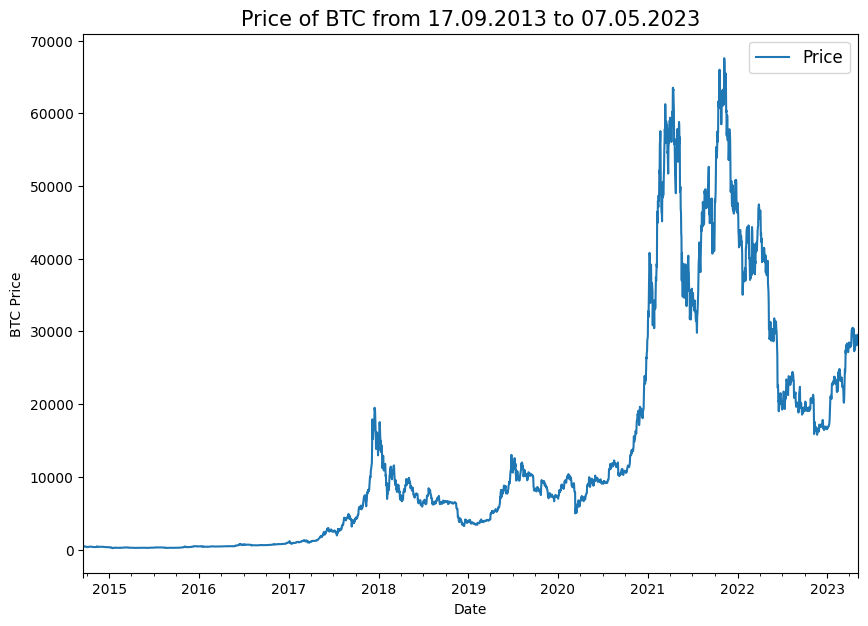

In [7]:
# Visualize the BTC price
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of BTC from 17.09.2013 to 07.05.2023', fontsize=15)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting data with Python CSV library
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv", 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  next(csv_reader) # goes through the iterator and ignores/skips next line - first line in our example
  
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates, not as strings
    btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Text(0, 0.5, 'BTC price')

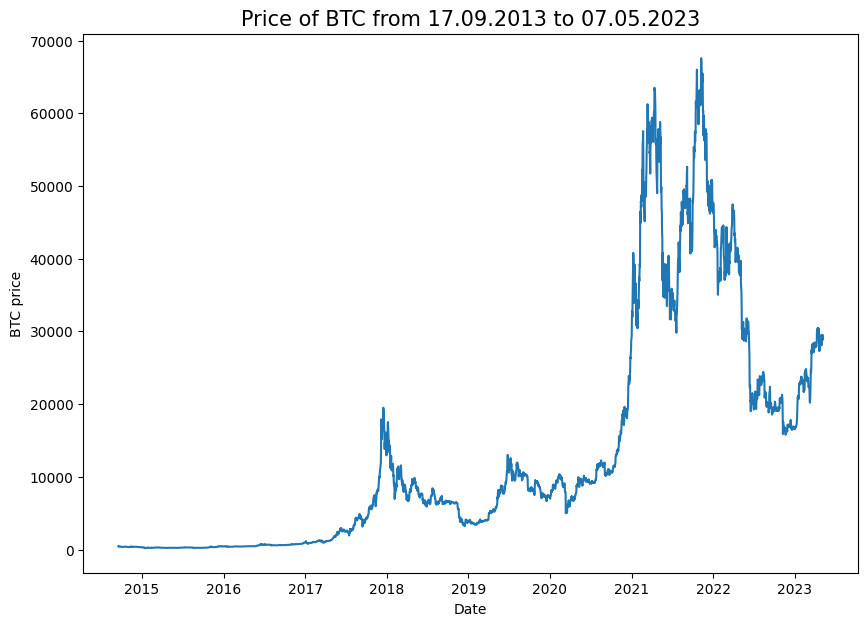

In [9]:
# Plot from Python CSV
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of BTC from 17.09.2013 to 07.05.2023", fontsize=15)
plt.xlabel("Date")
plt.ylabel("BTC price")

## Format data part 1: Create train and test sets of our times series data

### Creating training and test sets with time series data (the wrong way)

In [10]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2524,), (631,), (2524,), (631,))

Text(0.5, 1.0, 'Comparison of train and test datasets')

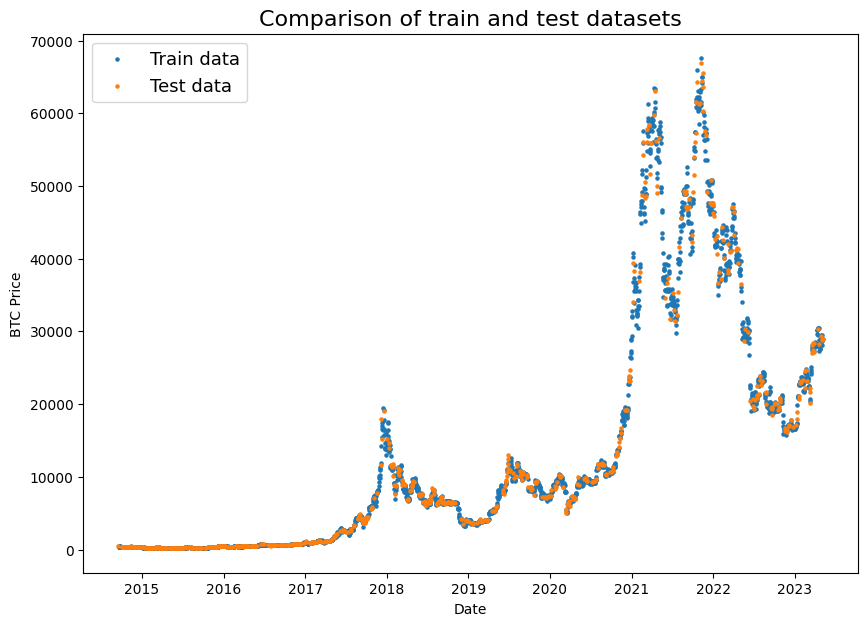

In [12]:
# Plotting wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

### Create the train and test sets for time series (the proper way)

In [13]:
split_size = int(0.8 * len(prices)) # 80% test, 20% test; can be changed as needed

# Create proper splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2524, 631, 2524, 631)

Text(0.5, 1.0, 'Comparison of train and test datasets')

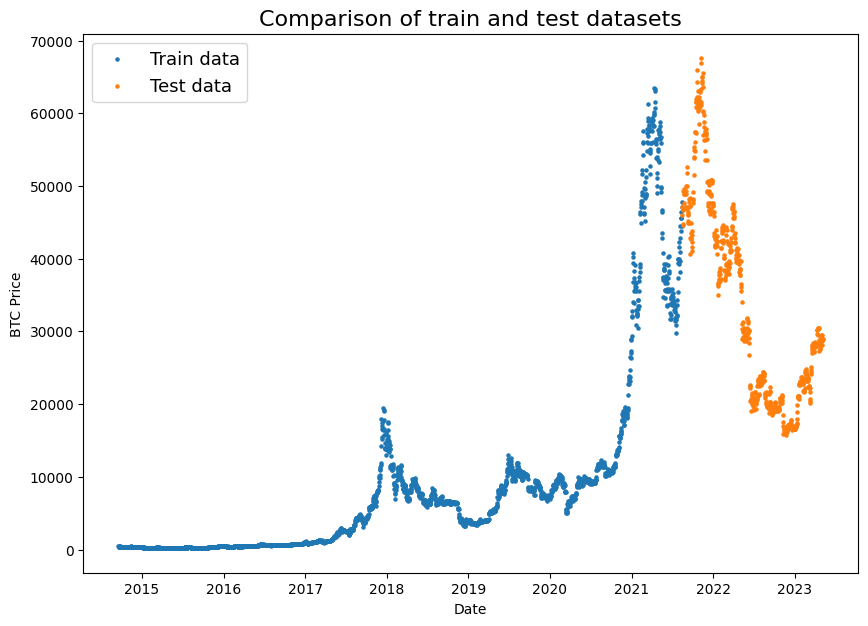

In [14]:
# Plot the correct splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

## Create a plotting function
As typing plotting code is tedious, it's time to functionize it.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) againt values (a series of values across timesteps).

  Parameters:
  -----------
  timesteps : array of timestep values
  values : array of values across time
  format: style of plot, default "."
  start: where to start the plot (indexing from start of timesteps and values)
  end: same as above, but end
  label: label to show on plot about values, default None
  """
  # Plot the series
  #plt.figure(figsize=(10,7))
  plt.plot(timesteps[start:end],
           values[start:end],
           format,
           label=label)
  
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

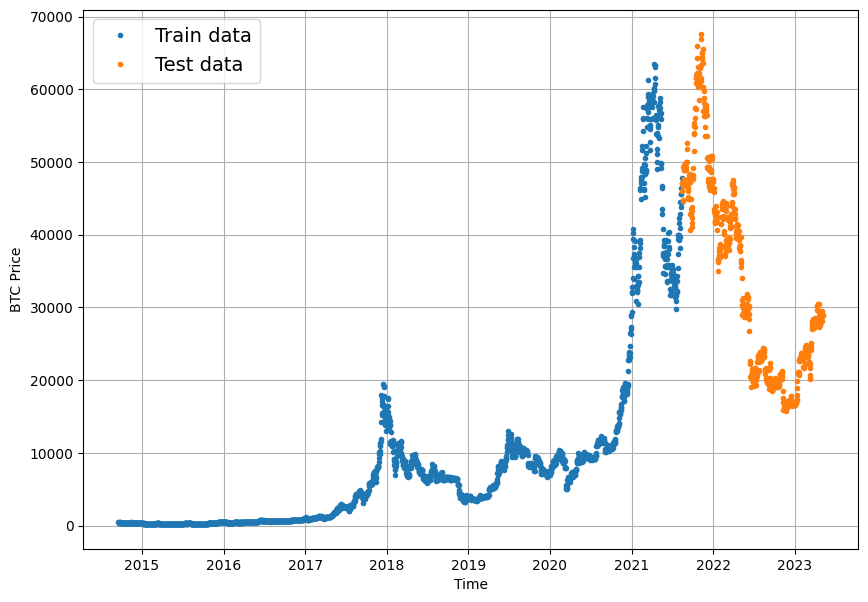

In [16]:
# Test the plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label='Train data')
plot_time_series(timesteps=X_test,
                 values=y_test,
                 label='Test data')

## Modelling experiments

We've got some historical Bitcoin data. It's about time to note down the experiments we'd like to run.

Terms to be familiar with:
* *horizon* - steps into the future to predict
* *window size* - number of timestep to be used to predict the *horizon*

Experiments will be as follows:
0. Naive based model (baseline)
1. Dense model: horizon = 1, window = 7
2. Same as model 1: horizon = 1, window = 7
3. Same as model 1: horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N_BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model
10. Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep **t** (y-hat) is equal to the value at timestep **t-1** (previous timestep) - this is for a horizon of 1.

Lecture for this section:
https://otexts.com/fpp3/simple-methods.html

In [17]:
# Creating a naive forecast 
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([47047.003906, 46004.484375, 44695.359375, 44801.1875  ,
        46717.578125, 49339.175781, 48905.492188, 49321.652344,
        49546.148438, 47706.117188]),
 array([29473.787109, 29340.261719, 29248.488281, 29268.806641,
        28091.568359, 28680.537109, 29006.308594, 28847.710938,
        29534.384766, 28904.623047]))

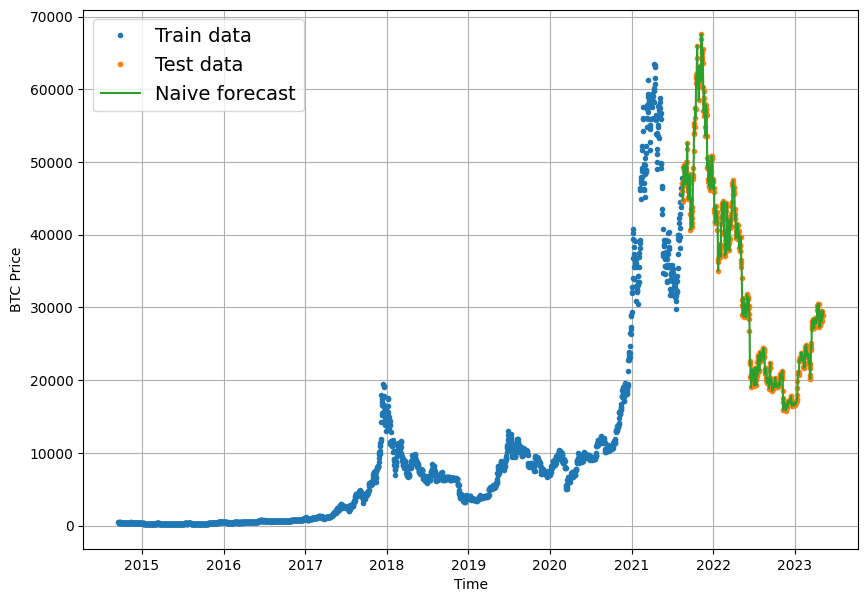

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

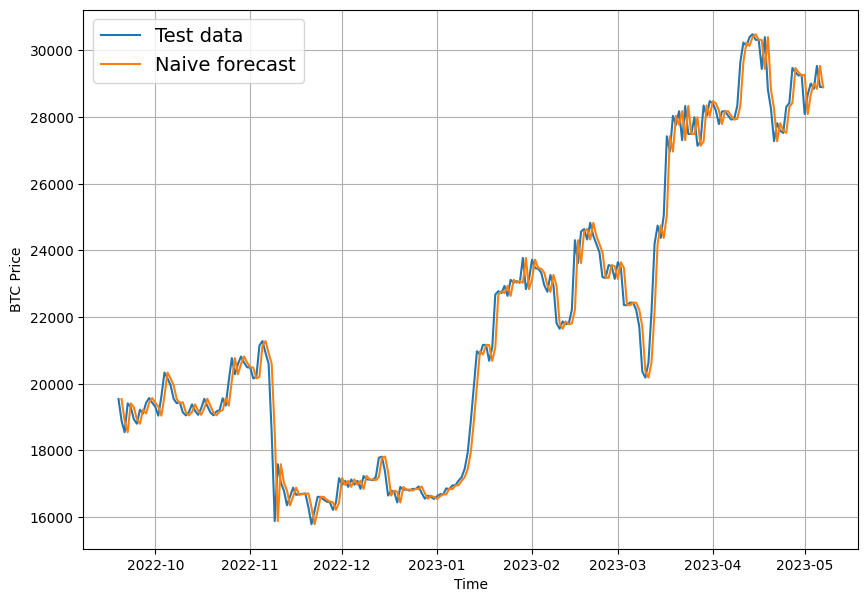

In [19]:
# Plot naive forecast - zoomed in version
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=400, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing? 

Predicting a number, so that means our problem is a **regression** problem. 

Because we're working on a regression problem, we're going to need some regression-like metrics.

A few common regression metrics, which also can be use for time series forecasting, are:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean sqaured error
* MAPE (sMAPE)- (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

Main thing we're evaluating here is: **how do our model's forecast (`y_pred`) compare agains the actual values (`y_true`).**

### Creating MASE function

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE metric (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:],
                           y_pred=naive_forecast).numpy()

1.0005690752533343

### Create a function for all of the metrics

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [24]:
# Get the Naive forecast results
naive_results = evaluate_preds(y_true=y_test[1:], 
                               y_pred=naive_forecast)
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

In [25]:
# Average, min & max price
print(f"Average price: {tf.reduce_mean(y_test):.2f} USD") 
print(f"Minimum price: {tf.reduce_min(y_test):.2f} USD") 
print(f"Maximum price: {tf.reduce_max(y_test):.2f} USD")

Average price: 32882.82 USD
Minimum price: 15787.28 USD
Maximum price: 67566.83 USD


## Other model you can use for baselines and for actual forecasts
In this notebook, the main focus is on TensorFlow and building deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with:
https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--exercises

## Format data part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [26]:
# What we want to do with our BTC data
print(f"We want to use this: {btc_price[:7]} \nto predict this: {btc_price[7]}")

We want to use this: [457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] 
to predict this: 423.204987


In [27]:
# Setting up global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use past 7 days to make a prediction

In [28]:
# Create a function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g.:
    if horizon = 1:
      Input = [0, 1, 2, 3, 4, 5, 6, 7]
      Output = ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data. However, it only works on a small scale.

We need the way to do the above across our entire time series...

We could do this with Python `for()` loops, however for large time series that would be quite slow.

To speed things up, we'll leverage `NumPy`'s array indexing.

The function will:
1. Create a windows step of a specific window size.
2. Use `Numpy` indexing to create 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]...]
```
3. Uses the 2D array of multiple window step to index on a target series. 
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with a specifide horizon.

> **Resource**: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (plus horizon)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window step (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(window_indexes, window_indexes.shape)

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3148, 3148)

In [32]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [33]:
# View the last 3 windows
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [29340.261719 29248.488281 29268.806641 28091.568359 28680.537109
 29006.308594 28847.710938] -> Label: [29534.384766]
Window: [29248.488281 29268.806641 28091.568359 28680.537109 29006.308594
 28847.710938 29534.384766] -> Label: [28904.623047]
Window: [29268.806641 28091.568359 28680.537109 29006.308594 28847.710938
 29534.384766 28904.623047] -> Label: [28897.636719]


> **NOTE**: There's a function that does similar to the above in `tf.keras.preprocessing`. You can try to replicate the above using said function.

Resource: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [34]:
# Another approach - data not separated as for window and horizon
sequence = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=None,
                                                        sequence_length=8,
                                                        sequence_stride=1,
                                                        sampling_rate=1,
                                                        batch_size=32)

for batch in sequence:
  print(batch)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  587.801025 592.103027]
 [578.289001 575.04303  587.778015 592.690002 591.054016 587.801025
  592.103027 589.119995]
 [575.04303  587.778015 592.690002 591.054016 587.801025 592.103027
  589.119995 587.559021]
 [587.778015 592.690002 591.054016 587.801025 592.103027 589.119995
  587.559021 585.588013]
 [592.690002 591.054016 587.801025 592.103027 589.119995 587.559021
  585.588013 570.473022]
 [591.054016 587.801025 592.103027 589.119995 587.559021 585.588013
  570.473022 567.23999 ]
 [587.801025 592.103027 589.119995 587.559021 585.588013 570.473022
  567.23999  577.439026]
 [592.103027 589.119995 587.559021 585.588013 570.473022 567.23999
  577.439026 573.216003]
 [589.119995 587.559021 585.588013 570.473022 567.23999  577.439026
  573.216003 574.317993]
 [587.559021 585.588013 570.473022 567.23999  577.439026 573.216003
  574.317993 575.630005]
 [585.588013 570.473022 567.23999  577.439026 573.216003 574.317993
  575.

In [35]:
# Another approach pt.2 - data separated as for window and horizon
input_data = prices[:-6]
targets = prices[7:]

sequence = tf.keras.utils.timeseries_dataset_from_array(data=input_data,
                                                        targets=targets,
                                                        sampling_rate=1,
                                                        sequence_length=7,
                                                        sequence_stride=1,
                                                        batch_size=32)


for batch in sequence:
  inputs, targets = batch
  #assert np.array_equal(inputs[0], prices[:7])
  #assert np.array_equal(targets[0], prices[7])
  #break
  print(inputs[1], targets[1])
print(prices[-10:])

tf.Tensor(
[424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987], shape=(7,), dtype=float64) tf.Tensor(411.574005, shape=(), dtype=float64)
tf.Tensor(
[382.845001 386.475006 383.15799  358.416992 358.345001 347.270996
 354.70401 ], shape=(7,), dtype=float64) tf.Tensor(352.989014, shape=(), dtype=float64)
tf.Tensor(
[350.847992 352.920013 367.572998 376.901001 375.347992 368.369995
 369.670013], shape=(7,), dtype=float64) tf.Tensor(376.446991, shape=(), dtype=float64)
tf.Tensor(
[334.571991 322.533997 319.007996 327.924011 315.863007 317.239014
 312.670013], shape=(7,), dtype=float64) tf.Tensor(310.737, shape=(), dtype=float64)
tf.Tensor(
[247.847    253.718002 273.472992 263.475006 233.914993 233.513
 226.425003], shape=(7,), dtype=float64) tf.Tensor(217.464005, shape=(), dtype=float64)
tf.Tensor(
[237.470001 236.425995 253.828003 254.263    260.201996 275.670013
 281.701996], shape=(7,), dtype=float64) tf.Tensor(273.09201, shape=(), dtype=float64)
tf.Tensor(


## Turning windows into training and test datasets

In [36]:
# Make the splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into test and train
  datasets.
  """
  split_size = int(len(windows) * (1 - test_split)) # default to 80% train / 20% test

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

In [38]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [39]:
# Chech to see if the train labels are the same (before and after the split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate, `ModelCheckpoint` is quite useful. This way we can compare apples to apples.

More specifically, we want to compare each of our model's best perfoemance against the other model's best performance.

For example, if our model performs best on epoch 55, but the training is for 100 epochs, we'd like to load and evaluate the model on the best epoch there was.


In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=1,
                                            save_best_only=True,
                                            monitor='val_loss')

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 units and ReLU activation funciton
* An output layer with a linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size = 128 (previously we've used 32)
* Epochs = 100

Why these values? They were picked out of experimenation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves.
* **Parameters** = values a model learns on its own.

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Set the random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # linear = no activation
], name='model_1_dense') # model name so we can save it

# 2. Compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              #batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
66/79 [========================>.....] - ETA: 0s - loss: 1026.3938 - mae: 1026.3938 - mse: 7899146.0000 
Epoch 1: val_loss improved from inf to 1889.45947, saving model to model_experiments/model_1_dense


79/79 [==============================] - 7s 13ms/step - loss: 953.5377 - mae: 953.5377 - mse: 6891031.0000 - val_loss: 1889.4595 - val_mae: 1889.4595 - val_mse: 6458274.5000
Epoch 2/100
73/79 [==========================>...] - ETA: 0s - loss: 484.9794 - mae: 484.9794 - mse: 1318852.5000
Epoch 2: val_loss improved from 1889.45947 to 1243.06616, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 480.0200 - mae: 480.0200 - mse: 1278030.3750 - val_loss: 1243.0662 - val_mae: 1243.0662 - val_mse: 3230064.2500
Epoch 3/100
71/79 [=========================>....] - ETA: 0s - loss: 451.2821 - mae: 451.2821 - mse: 1080207.3750
Epoch 3: val_loss improved from 1243.06616 to 1158.21875, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 14ms/step - loss: 447.1415 - mae: 447.1415 - mse: 1050534.2500 - val_loss: 1158.2188 - val_mae: 1158.2188 - val_mse: 2810986.7500
Epoch 4/100
76/79 [===========================>..] - ETA: 0s - loss: 402.3791 - mae: 402.3791 - mse: 889698.6250
Epoch 4: val_loss did not improve from 1158.21875
79/79 [==============================] - 0s 5ms/step - loss: 404.5416 - mae: 404.5416 - mse: 898899.1875 - val_loss: 1404.8263 - val_mae: 1404.8263 - val_mse: 3749284.5000
Epoch 5/100
78/79 [============================>.] - ETA: 0s - loss: 414.2479 - mae: 414.2479 - mse: 932291.6875
Epoch 5: val_loss improved from 1158.21875 to 1148.51697, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 13ms/step - loss: 413.8629 - mae: 413.8629 - mse: 931707.3125 - val_loss: 1148.5170 - val_mae: 1148.5170 - val_mse: 2692180.5000
Epoch 6/100
79/79 [==============================] - ETA: 0s - loss: 383.9971 - mae: 383.9971 - mse: 819196.9375
Epoch 6: val_loss did not improve from 1148.51697
79/79 [==============================] - 0s 5ms/step - loss: 383.9971 - mae: 383.9971 - mse: 819196.9375 - val_loss: 1352.3245 - val_mae: 1352.3245 - val_mse: 3436154.7500
Epoch 7/100
76/79 [===========================>..] - ETA: 0s - loss: 353.2630 - mae: 353.2630 - mse: 703919.2500
Epoch 7: val_loss did not improve from 1148.51697
79/79 [==============================] - 0s 5ms/step - loss: 351.3875 - mae: 351.3875 - mse: 695611.1875 - val_loss: 1176.2026 - val_mae: 1176.2026 - val_mse: 2760837.0000
Epoch 8/100
69/79 [=========================>....] - ETA: 0s - loss: 351.0403 - mae: 351.0403 - mse: 651977.1875
Epoch 8: val_loss did not improve from 1148.

79/79 [==============================] - 1s 10ms/step - loss: 360.7696 - mae: 360.7696 - mse: 694430.1250 - val_loss: 950.5604 - val_mae: 950.5604 - val_mse: 1974189.8750
Epoch 10/100
72/79 [==========================>...] - ETA: 0s - loss: 324.8070 - mae: 324.8070 - mse: 605199.2500
Epoch 10: val_loss improved from 950.56042 to 893.18036, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 326.6484 - mae: 326.6484 - mse: 607397.9375 - val_loss: 893.1804 - val_mae: 893.1804 - val_mse: 1721714.3750
Epoch 11/100
76/79 [===========================>..] - ETA: 0s - loss: 314.6084 - mae: 314.6084 - mse: 561557.5625
Epoch 11: val_loss did not improve from 893.18036
79/79 [==============================] - 0s 4ms/step - loss: 312.0692 - mae: 312.0692 - mse: 549459.1875 - val_loss: 937.8911 - val_mae: 937.8911 - val_mse: 1922265.7500
Epoch 12/100
77/79 [============================>.] - ETA: 0s - loss: 322.6548 - mae: 322.6548 - mse: 575496.7500
Epoch 12: val_loss did not improve from 893.18036
79/79 [==============================] - 0s 4ms/step - loss: 319.0072 - mae: 319.0072 - mse: 566852.0000 - val_loss: 1050.8927 - val_mae: 1050.8927 - val_mse: 2254735.0000
Epoch 13/100
73/79 [==========================>...] - ETA: 0s - loss: 306.2061 - mae: 306.2061 - mse: 532426.6250
Epoch 13: val_loss did not improve from 893.1

79/79 [==============================] - 1s 9ms/step - loss: 303.6938 - mae: 303.6938 - mse: 517939.6875 - val_loss: 827.2288 - val_mae: 827.2288 - val_mse: 1544302.2500
Epoch 17/100
74/79 [===========================>..] - ETA: 0s - loss: 300.8605 - mae: 300.8605 - mse: 528583.8125
Epoch 17: val_loss did not improve from 827.22882
79/79 [==============================] - 0s 4ms/step - loss: 302.0372 - mae: 302.0372 - mse: 525165.9375 - val_loss: 1010.7678 - val_mae: 1010.7678 - val_mse: 2074488.2500
Epoch 18/100
70/79 [=========================>....] - ETA: 0s - loss: 284.8112 - mae: 284.8112 - mse: 498239.1562
Epoch 18: val_loss did not improve from 827.22882
79/79 [==============================] - 0s 4ms/step - loss: 284.8138 - mae: 284.8138 - mse: 495097.6875 - val_loss: 846.2408 - val_mae: 846.2408 - val_mse: 1616995.5000
Epoch 19/100
72/79 [==========================>...] - ETA: 0s - loss: 322.3033 - mae: 322.3033 - mse: 596673.8750
Epoch 19: val_loss did not improve from 827.22

79/79 [==============================] - 1s 12ms/step - loss: 323.0439 - mae: 323.0439 - mse: 596983.7500 - val_loss: 816.2043 - val_mae: 816.2043 - val_mse: 1539630.2500
Epoch 21/100
76/79 [===========================>..] - ETA: 0s - loss: 277.4861 - mae: 277.4861 - mse: 475566.7812
Epoch 21: val_loss did not improve from 816.20428
79/79 [==============================] - 0s 4ms/step - loss: 280.6178 - mae: 280.6178 - mse: 482469.2188 - val_loss: 864.7373 - val_mae: 864.7373 - val_mse: 1588980.7500
Epoch 22/100
71/79 [=========================>....] - ETA: 0s - loss: 282.4463 - mae: 282.4463 - mse: 496581.6250
Epoch 22: val_loss did not improve from 816.20428
79/79 [==============================] - 0s 4ms/step - loss: 285.8297 - mae: 285.8297 - mse: 496950.0000 - val_loss: 881.2684 - val_mae: 881.2684 - val_mse: 1625244.5000
Epoch 23/100
74/79 [===========================>..] - ETA: 0s - loss: 297.6671 - mae: 297.6671 - mse: 500567.6250
Epoch 23: val_loss did not improve from 816.204

79/79 [==============================] - 1s 10ms/step - loss: 287.3358 - mae: 287.3358 - mse: 500785.0625 - val_loss: 803.7190 - val_mae: 803.7190 - val_mse: 1466281.0000
Epoch 26/100
74/79 [===========================>..] - ETA: 0s - loss: 281.3260 - mae: 281.3260 - mse: 475034.6562
Epoch 26: val_loss did not improve from 803.71899
79/79 [==============================] - 0s 4ms/step - loss: 287.2104 - mae: 287.2104 - mse: 495794.6250 - val_loss: 1044.0911 - val_mae: 1044.0911 - val_mse: 2145906.7500
Epoch 27/100
79/79 [==============================] - ETA: 0s - loss: 279.1356 - mae: 279.1356 - mse: 455055.2500
Epoch 27: val_loss improved from 803.71899 to 795.44391, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 279.1356 - mae: 279.1356 - mse: 455055.2500 - val_loss: 795.4439 - val_mae: 795.4439 - val_mse: 1484054.8750
Epoch 28/100
79/79 [==============================] - ETA: 0s - loss: 278.3873 - mae: 278.3873 - mse: 470978.0312
Epoch 28: val_loss did not improve from 795.44391
79/79 [==============================] - 0s 4ms/step - loss: 278.3873 - mae: 278.3873 - mse: 470978.0312 - val_loss: 833.4595 - val_mae: 833.4595 - val_mse: 1568100.7500
Epoch 29/100
79/79 [==============================] - ETA: 0s - loss: 291.7293 - mae: 291.7293 - mse: 516883.8125
Epoch 29: val_loss did not improve from 795.44391
79/79 [==============================] - 0s 4ms/step - loss: 291.7293 - mae: 291.7293 - mse: 516883.8125 - val_loss: 850.4202 - val_mae: 850.4202 - val_mse: 1551041.6250
Epoch 30/100
77/79 [============================>.] - ETA: 0s - loss: 280.7337 - mae: 280.7337 - mse: 482234.6562
Epoch 30: val_loss did not improve from 795.4439

79/79 [==============================] - 1s 13ms/step - loss: 293.2383 - mae: 293.2383 - mse: 515839.3438 - val_loss: 788.9119 - val_mae: 788.9119 - val_mse: 1436757.7500
Epoch 35/100
68/79 [========================>.....] - ETA: 0s - loss: 266.6943 - mae: 266.6943 - mse: 460927.2500
Epoch 35: val_loss improved from 788.91187 to 788.22015, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 13ms/step - loss: 272.8633 - mae: 272.8633 - mse: 474404.9062 - val_loss: 788.2202 - val_mae: 788.2202 - val_mse: 1434734.6250
Epoch 36/100
79/79 [==============================] - ETA: 0s - loss: 290.6938 - mae: 290.6938 - mse: 493561.1250
Epoch 36: val_loss did not improve from 788.22015
79/79 [==============================] - 0s 4ms/step - loss: 290.6938 - mae: 290.6938 - mse: 493561.1250 - val_loss: 1302.7402 - val_mae: 1302.7402 - val_mse: 2979941.2500
Epoch 37/100
75/79 [===========================>..] - ETA: 0s - loss: 326.4543 - mae: 326.4543 - mse: 566563.0625
Epoch 37: val_loss did not improve from 788.22015
79/79 [==============================] - 0s 4ms/step - loss: 323.0499 - mae: 323.0499 - mse: 553318.2500 - val_loss: 793.7575 - val_mae: 793.7575 - val_mse: 1442639.5000
Epoch 38/100
75/79 [===========================>..] - ETA: 0s - loss: 272.8988 - mae: 272.8988 - mse: 456816.3750
Epoch 38: val_loss did not improve from 788.2

79/79 [==============================] - 1s 9ms/step - loss: 276.5215 - mae: 276.5215 - mse: 470593.0625 - val_loss: 777.3451 - val_mae: 777.3451 - val_mse: 1423938.5000
Epoch 42/100
76/79 [===========================>..] - ETA: 0s - loss: 276.4275 - mae: 276.4275 - mse: 457395.5938
Epoch 42: val_loss did not improve from 777.34509
79/79 [==============================] - 0s 4ms/step - loss: 277.7806 - mae: 277.7806 - mse: 463445.2500 - val_loss: 819.0855 - val_mae: 819.0855 - val_mse: 1486857.3750
Epoch 43/100
70/79 [=========================>....] - ETA: 0s - loss: 285.8846 - mae: 285.8846 - mse: 506419.5938
Epoch 43: val_loss did not improve from 777.34509
79/79 [==============================] - 0s 4ms/step - loss: 278.4853 - mae: 278.4853 - mse: 480905.0000 - val_loss: 847.3991 - val_mae: 847.3991 - val_mse: 1591613.0000
Epoch 44/100
72/79 [==========================>...] - ETA: 0s - loss: 279.4241 - mae: 279.4241 - mse: 438439.5000
Epoch 44: val_loss did not improve from 777.3450

79/79 [==============================] - 1s 9ms/step - loss: 291.5401 - mae: 291.5401 - mse: 504759.3438 - val_loss: 776.8048 - val_mae: 776.8048 - val_mse: 1411367.3750
Epoch 58/100
70/79 [=========================>....] - ETA: 0s - loss: 286.0603 - mae: 286.0603 - mse: 499570.4688
Epoch 58: val_loss did not improve from 776.80481
79/79 [==============================] - 0s 4ms/step - loss: 281.2093 - mae: 281.2093 - mse: 483227.5000 - val_loss: 857.8346 - val_mae: 857.8346 - val_mse: 1621722.2500
Epoch 59/100
74/79 [===========================>..] - ETA: 0s - loss: 280.1635 - mae: 280.1635 - mse: 491140.0938
Epoch 59: val_loss improved from 776.80481 to 774.53302, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 283.8163 - mae: 283.8163 - mse: 501052.8438 - val_loss: 774.5330 - val_mae: 774.5330 - val_mse: 1411032.6250
Epoch 60/100
75/79 [===========================>..] - ETA: 0s - loss: 279.9754 - mae: 279.9754 - mse: 462940.0938
Epoch 60: val_loss did not improve from 774.53302
79/79 [==============================] - 0s 4ms/step - loss: 276.4930 - mae: 276.4930 - mse: 455804.5000 - val_loss: 841.6647 - val_mae: 841.6647 - val_mse: 1575998.3750
Epoch 61/100
75/79 [===========================>..] - ETA: 0s - loss: 274.7200 - mae: 274.7200 - mse: 457316.4688
Epoch 61: val_loss improved from 774.53302 to 774.28326, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 275.3269 - mae: 275.3269 - mse: 469395.7188 - val_loss: 774.2833 - val_mae: 774.2833 - val_mse: 1411505.6250
Epoch 62/100
71/79 [=========================>....] - ETA: 0s - loss: 293.0616 - mae: 293.0616 - mse: 531812.8750
Epoch 62: val_loss did not improve from 774.28326
79/79 [==============================] - 0s 4ms/step - loss: 288.1263 - mae: 288.1263 - mse: 510997.9688 - val_loss: 796.9096 - val_mae: 796.9096 - val_mse: 1441011.7500
Epoch 63/100
74/79 [===========================>..] - ETA: 0s - loss: 265.4507 - mae: 265.4507 - mse: 447479.2500
Epoch 63: val_loss did not improve from 774.28326
79/79 [==============================] - 0s 6ms/step - loss: 271.6317 - mae: 271.6317 - mse: 456432.8438 - val_loss: 995.3055 - val_mae: 995.3055 - val_mse: 1987013.1250
Epoch 64/100
79/79 [==============================] - ETA: 0s - loss: 277.1693 - mae: 277.1693 - mse: 490939.9688
Epoch 64: val_loss did not improve from 774.2832

79/79 [==============================] - 1s 14ms/step - loss: 312.0878 - mae: 312.0878 - mse: 530287.5625 - val_loss: 771.5410 - val_mae: 771.5410 - val_mse: 1404546.1250
Epoch 69/100
72/79 [==========================>...] - ETA: 0s - loss: 289.5501 - mae: 289.5501 - mse: 496828.5625
Epoch 69: val_loss did not improve from 771.54102
79/79 [==============================] - 0s 5ms/step - loss: 286.8215 - mae: 286.8215 - mse: 486400.4688 - val_loss: 982.2243 - val_mae: 982.2243 - val_mse: 1945099.7500
Epoch 70/100
67/79 [========================>.....] - ETA: 0s - loss: 276.0154 - mae: 276.0154 - mse: 433585.9375
Epoch 70: val_loss did not improve from 771.54102
79/79 [==============================] - 0s 4ms/step - loss: 275.8056 - mae: 275.8056 - mse: 446738.3438 - val_loss: 774.0216 - val_mae: 774.0216 - val_mse: 1409685.0000
Epoch 71/100
74/79 [===========================>..] - ETA: 0s - loss: 279.0046 - mae: 279.0046 - mse: 468998.3750
Epoch 71: val_loss did not improve from 771.541

In [42]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 817.1834 - mae: 817.1834 - mse: 1475891.7500


[817.1834106445312, 817.1834106445312, 1475891.75]

In [43]:
# Load in the saved, best performat model
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 771.5410 - mae: 771.5410 - mse: 1404546.1250


[771.541015625, 771.541015625, 1404546.125]

### Make forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset, let's write a function to:
1. Takes in a trained model
2. Takes in some input data
3. Passes the input to the `predict()` method
4. Returns the predictions

In [44]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # 1D array of preds as output

In [45]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

20/20 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([47112.418, 46079.348, 44817.355, 44785.562, 46435.035, 49003.793,
        48877.504, 49303.61 , 49608.215, 48017.82 ], dtype=float32)>,
 630)

In [46]:
# Shapes had to be changes 
test_labels.shape, model_1_preds.shape

((630, 1), TensorShape([630]))

In [47]:
# Evaluate our preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 771.5409,
 'mse': 1404546.1,
 'rmse': 1185.1355,
 'mape': 2.2753763,
 'mase': 1.0054026}

In [48]:
# Naive results
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

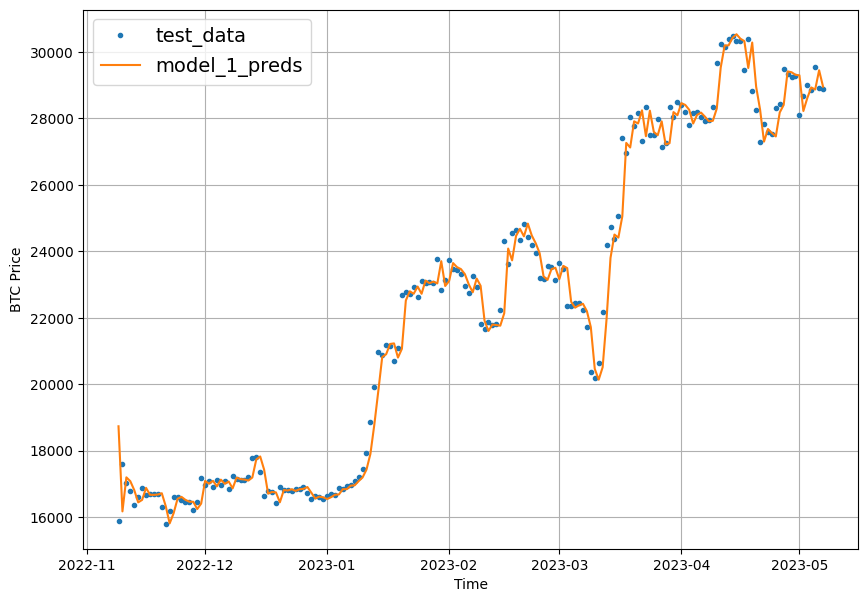

In [49]:
# Let's plot model_1 predictions 
offset=450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 format="-",
                 start=offset, 
                 label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
# Update global variables
HORIZON = 1
WINDOW_SIZE = 30

In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3125, 3125)

In [52]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2500, 625, 2500, 625)

In [53]:
train_windows[:3], train_labels[:3]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005, 404.424988, 399.519989, 377.181   ,
         375.46701 , 386.944   ,

In [54]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# Compile the model
model_2.compile(loss='mae',
                optimizer='adam',
                metrics=['mse', 'mae'])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


Epoch 1: val_loss improved from inf to 4335.05273, saving model to model_experiments/model_2_dense



Epoch 2: val_loss improved from 4335.05273 to 2687.69312, saving model to model_experiments/model_2_dense



Epoch 3: val_loss improved from 2687.69312 to 1721.37695, saving model to model_experiments/model_2_dense



Epoch 4: val_loss improved from 1721.37695 to 1491.18604, saving model to model_experiments/model_2_dense



Epoch 5: val_loss did not improve from 1491.18604

Epoch 6: val_loss did not improve from 1491.18604

Epoch 7: val_loss did not improve from 1491.18604

Epoch 8: val_loss improved from 1491.18604 to 1311.71399, saving model to model_experiments/model_2_dense



Epoch 9: val_loss did not improve from 1311.71399

Epoch 10: val_loss improved from 1311.71399 to 1196.19995, saving model to model_experiments/model_2_dense



Epoch 11: val_loss did not improve from 1196.19995

Epoch 12: val_loss improved from 1196.19995 to 1169.50000, saving model to model_experiments/model_2_dense



Epoch 13: val_loss did not improve from 1169.50000

Epoch 14: val_loss improved from 1169.50000 to 1128.97986, saving model to model_experiments/model_2_dense



Epoch 15: val_loss improved from 1128.97986 to 1119.95251, saving model to model_experiments/model_2_dense



Epoch 16: val_loss did not improve from 1119.95251

Epoch 17: val_loss improved from 1119.95251 to 1106.10205, saving model to model_experiments/model_2_dense



Epoch 18: val_loss improved from 1106.10205 to 1081.84778, saving model to model_experiments/model_2_dense



Epoch 19: val_loss did not improve from 1081.84778

Epoch 20: val_loss did not improve from 1081.84778

Epoch 21: val_loss improved from 1081.84778 to 1072.46277, saving model to model_experiments/model_2_dense



Epoch 22: val_loss did not improve from 1072.46277

Epoch 23: val_loss did not improve from 1072.46277

Epoch 24: val_loss did not improve from 1072.46277

Epoch 25: val_loss did not improve from 1072.46277

Epoch 26: val_loss did not improve from 1072.46277

Epoch 27: val_loss did not improve from 1072.46277

Epoch 28: val_loss did not improve from 1072.46277

Epoch 29: val_loss improved from 1072.46277 to 1011.16937, saving model to model_experiments/model_2_dense



Epoch 30: val_loss improved from 1011.16937 to 991.70129, saving model to model_experiments/model_2_dense



Epoch 31: val_loss improved from 991.70129 to 969.58899, saving model to model_experiments/model_2_dense



Epoch 32: val_loss did not improve from 969.58899

Epoch 33: val_loss did not improve from 969.58899

Epoch 34: val_loss did not improve from 969.58899

Epoch 35: val_loss did not improve from 969.58899

Epoch 36: val_loss did not improve from 969.58899

Epoch 37: val_loss improved from 969.58899 to 968.06299, saving model to model_experiments/model_2_dense



Epoch 38: val_loss did not improve from 968.06299

Epoch 39: val_loss did not improve from 968.06299

Epoch 40: val_loss improved from 968.06299 to 950.81641, saving model to model_experiments/model_2_dense



Epoch 41: val_loss did not improve from 950.81641

Epoch 42: val_loss did not improve from 950.81641

Epoch 43: val_loss improved from 950.81641 to 942.59509, saving model to model_experiments/model_2_dense



Epoch 44: val_loss did not improve from 942.59509

Epoch 45: val_loss improved from 942.59509 to 917.30090, saving model to model_experiments/model_2_dense



Epoch 46: val_loss improved from 917.30090 to 915.41217, saving model to model_experiments/model_2_dense



Epoch 47: val_loss did not improve from 915.41217

Epoch 48: val_loss improved from 915.41217 to 912.00342, saving model to model_experiments/model_2_dense



Epoch 49: val_loss improved from 912.00342 to 905.30353, saving model to model_experiments/model_2_dense



Epoch 50: val_loss did not improve from 905.30353

Epoch 51: val_loss did not improve from 905.30353

Epoch 52: val_loss did not improve from 905.30353

Epoch 53: val_loss did not improve from 905.30353

Epoch 54: val_loss did not improve from 905.30353

Epoch 55: val_loss did not improve from 905.30353

Epoch 56: val_loss did not improve from 905.30353

Epoch 57: val_loss did not improve from 905.30353

Epoch 58: val_loss did not improve from 905.30353

Epoch 59: val_loss did not improve from 905.30353

Epoch 60: val_loss did not improve from 905.30353

Epoch 61: val_loss did not improve from 905.30353

Epoch 62: val_loss did not improve from 905.30353

Epoch 63: val_loss did not improve from 905.30353

Epoch 64: val_loss did not improve from 905.30353

Epoch 65: val_loss did not improve from 905.30353

Epoch 66: val_loss improved from 905.30353 to 864.00732, saving model to model_experiments/model_2_dense



Epoch 67: val_loss did not improve from 864.00732

Epoch 68: val_loss did not improve from 864.00732

Epoch 69: val_loss improved from 864.00732 to 855.21863, saving model to model_experiments/model_2_dense



Epoch 70: val_loss did not improve from 855.21863

Epoch 71: val_loss did not improve from 855.21863

Epoch 72: val_loss did not improve from 855.21863

Epoch 73: val_loss did not improve from 855.21863

Epoch 74: val_loss did not improve from 855.21863

Epoch 75: val_loss did not improve from 855.21863

Epoch 76: val_loss improved from 855.21863 to 852.23090, saving model to model_experiments/model_2_dense



Epoch 77: val_loss did not improve from 852.23090

Epoch 78: val_loss improved from 852.23090 to 850.66162, saving model to model_experiments/model_2_dense



Epoch 79: val_loss did not improve from 850.66162

Epoch 80: val_loss did not improve from 850.66162

Epoch 81: val_loss improved from 850.66162 to 849.56921, saving model to model_experiments/model_2_dense



Epoch 82: val_loss did not improve from 849.56921

Epoch 83: val_loss did not improve from 849.56921

Epoch 84: val_loss did not improve from 849.56921

Epoch 85: val_loss did not improve from 849.56921

Epoch 86: val_loss did not improve from 849.56921

Epoch 87: val_loss did not improve from 849.56921

Epoch 88: val_loss improved from 849.56921 to 845.12439, saving model to model_experiments/model_2_dense



Epoch 89: val_loss did not improve from 845.12439

Epoch 90: val_loss did not improve from 845.12439

Epoch 91: val_loss did not improve from 845.12439

Epoch 92: val_loss did not improve from 845.12439

Epoch 93: val_loss did not improve from 845.12439

Epoch 94: val_loss did not improve from 845.12439

Epoch 95: val_loss did not improve from 845.12439

Epoch 96: val_loss did not improve from 845.12439

Epoch 97: val_loss did not improve from 845.12439

Epoch 98: val_loss did not improve from 845.12439

Epoch 99: val_loss did not improve from 845.12439

Epoch 100: val_loss did not improve from 845.12439


In [55]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 914.4821 - mse: 1740361.7500 - mae: 914.4821


[914.4821166992188, 1740361.75, 914.4821166992188]

In [56]:
# Load in the best performant model_2
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 845.1245 - mse: 1604256.0000 - mae: 845.1245


[845.12451171875, 1604256.0, 845.12451171875]

In [57]:
# Get the forecast predicions
model_2_preds = make_preds(model_2, test_windows)

20/20 [==============================] - 0s 1ms/step


In [58]:
# Evaluate results for model_2 prediction
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 845.1245,
 'mse': 1604256.4,
 'rmse': 1266.5924,
 'mape': 2.511654,
 'mase': 1.1071852}

In [59]:
model_1_results

{'mae': 771.5409,
 'mse': 1404546.1,
 'rmse': 1185.1355,
 'mape': 2.2753763,
 'mase': 1.0054026}

In [60]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

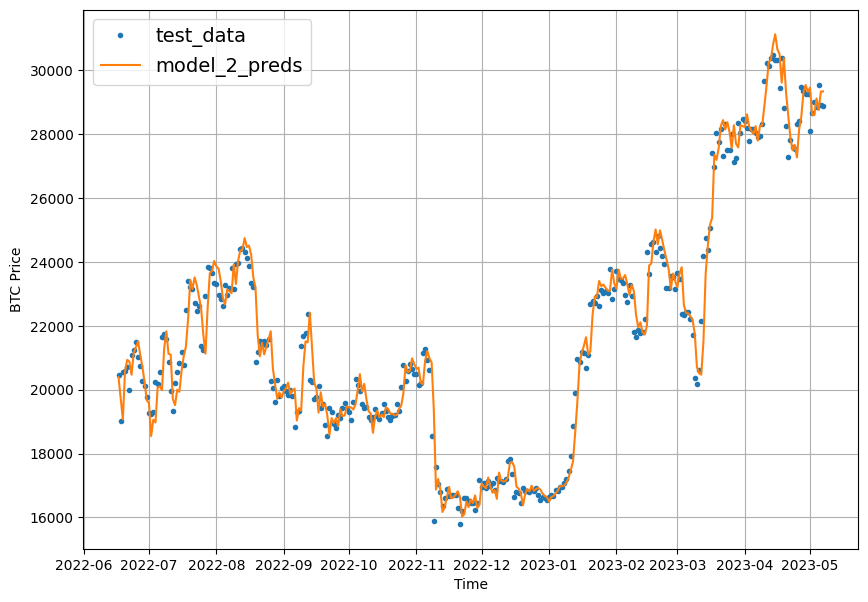

In [61]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label='model_2_preds')

## Model 3: Dense (window = 30, horizon = 7)

In [62]:
# Update global variables
HORIZON = 7
WINDOW_SIZE = 30

In [63]:
# Create new windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3119, 3119)

In [64]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2495, 624, 2495, 624)

In [65]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile the model
model_3.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])


Epoch 1: val_loss improved from inf to 4098.79980, saving model to model_experiments/model_3_dense



Epoch 2: val_loss improved from 4098.79980 to 2678.23315, saving model to model_experiments/model_3_dense



Epoch 3: val_loss improved from 2678.23315 to 2599.31665, saving model to model_experiments/model_3_dense



Epoch 4: val_loss improved from 2599.31665 to 2336.27124, saving model to model_experiments/model_3_dense



Epoch 5: val_loss did not improve from 2336.27124

Epoch 6: val_loss improved from 2336.27124 to 2070.90088, saving model to model_experiments/model_3_dense



Epoch 7: val_loss did not improve from 2070.90088

Epoch 8: val_loss did not improve from 2070.90088

Epoch 9: val_loss improved from 2070.90088 to 2037.70349, saving model to model_experiments/model_3_dense



Epoch 10: val_loss did not improve from 2037.70349

Epoch 11: val_loss improved from 2037.70349 to 1958.59692, saving model to model_experiments/model_3_dense



Epoch 12: val_loss improved from 1958.59692 to 1922.55994, saving model to model_experiments/model_3_dense



Epoch 13: val_loss did not improve from 1922.55994

Epoch 14: val_loss did not improve from 1922.55994

Epoch 15: val_loss did not improve from 1922.55994

Epoch 16: val_loss did not improve from 1922.55994

Epoch 17: val_loss did not improve from 1922.55994

Epoch 18: val_loss improved from 1922.55994 to 1734.34412, saving model to model_experiments/model_3_dense



Epoch 19: val_loss did not improve from 1734.34412

Epoch 20: val_loss did not improve from 1734.34412

Epoch 21: val_loss did not improve from 1734.34412

Epoch 22: val_loss did not improve from 1734.34412

Epoch 23: val_loss improved from 1734.34412 to 1712.18286, saving model to model_experiments/model_3_dense



Epoch 24: val_loss did not improve from 1712.18286

Epoch 25: val_loss did not improve from 1712.18286

Epoch 26: val_loss improved from 1712.18286 to 1698.25195, saving model to model_experiments/model_3_dense



Epoch 27: val_loss did not improve from 1698.25195

Epoch 28: val_loss did not improve from 1698.25195

Epoch 29: val_loss did not improve from 1698.25195

Epoch 30: val_loss improved from 1698.25195 to 1698.10693, saving model to model_experiments/model_3_dense



Epoch 31: val_loss did not improve from 1698.10693

Epoch 32: val_loss did not improve from 1698.10693

Epoch 33: val_loss improved from 1698.10693 to 1672.15173, saving model to model_experiments/model_3_dense



Epoch 34: val_loss did not improve from 1672.15173

Epoch 35: val_loss did not improve from 1672.15173

Epoch 36: val_loss did not improve from 1672.15173

Epoch 37: val_loss did not improve from 1672.15173

Epoch 38: val_loss did not improve from 1672.15173

Epoch 39: val_loss did not improve from 1672.15173

Epoch 40: val_loss did not improve from 1672.15173

Epoch 41: val_loss did not improve from 1672.15173

Epoch 42: val_loss did not improve from 1672.15173

Epoch 43: val_loss did not improve from 1672.15173

Epoch 44: val_loss did not improve from 1672.15173

Epoch 45: val_loss improved from 1672.15173 to 1670.38904, saving model to model_experiments/model_3_dense



Epoch 46: val_loss did not improve from 1670.38904

Epoch 47: val_loss did not improve from 1670.38904

Epoch 48: val_loss did not improve from 1670.38904

Epoch 49: val_loss improved from 1670.38904 to 1652.38220, saving model to model_experiments/model_3_dense



Epoch 50: val_loss did not improve from 1652.38220

Epoch 51: val_loss did not improve from 1652.38220

Epoch 52: val_loss did not improve from 1652.38220

Epoch 53: val_loss did not improve from 1652.38220

Epoch 54: val_loss did not improve from 1652.38220

Epoch 55: val_loss did not improve from 1652.38220

Epoch 56: val_loss did not improve from 1652.38220

Epoch 57: val_loss did not improve from 1652.38220

Epoch 58: val_loss did not improve from 1652.38220

Epoch 59: val_loss did not improve from 1652.38220

Epoch 60: val_loss did not improve from 1652.38220

Epoch 61: val_loss did not improve from 1652.38220

Epoch 62: val_loss did not improve from 1652.38220

Epoch 63: val_loss did not improve from 1652.38220

Epoch 64: val_loss did not improve from 1652.38220

Epoch 65: val_loss did not improve from 1652.38220

Epoch 66: val_loss did not improve from 1652.38220

Epoch 67: val_loss did not improve from 1652.38220

Epoch 68: val_loss did not improve from 1652.38220

Epoch 69: v


Epoch 92: val_loss did not improve from 1636.25024

Epoch 93: val_loss did not improve from 1636.25024

Epoch 94: val_loss did not improve from 1636.25024

Epoch 95: val_loss did not improve from 1636.25024

Epoch 96: val_loss did not improve from 1636.25024

Epoch 97: val_loss did not improve from 1636.25024

Epoch 98: val_loss did not improve from 1636.25024

Epoch 99: val_loss did not improve from 1636.25024

Epoch 100: val_loss did not improve from 1636.25024


In [66]:
# Evaluate the model
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1740.8602 - mae: 1740.8602 - mse: 6377542.0000


[1740.8602294921875, 1740.8602294921875, 6377542.0]

In [67]:
# Evaluate the best epoch
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1636.2502 - mae: 1636.2502 - mse: 5805656.5000


[1636.250244140625, 1636.250244140625, 5805656.5]

In [68]:
# Make the predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[46424.76 , 47652.645, 47570.84 , 47764.92 , 47633.055, 46840.53 ,
        47229.457],
       [45791.605, 46226.38 , 47060.965, 46386.34 , 47428.543, 46233.72 ,
        47335.938],
       [44697.457, 45148.29 , 45524.74 , 44756.836, 46012.875, 45370.38 ,
        45907.426],
       [44728.574, 44793.41 , 44810.84 , 44650.797, 46470.53 , 45117.855,
        46342.27 ],
       [46136.76 , 45891.227, 46701.918, 46737.484, 47941.03 , 47166.023,
        47036.793]], dtype=float32)>

In [69]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([1865.4052 , 1798.9648 , 2702.7644 , 3368.9536 , 1967.0475 ,
        1200.8381 , 1914.4481 , 2136.1802 , 2157.2222 , 1116.0742 ,
        1157.8365 , 1642.2869 , 1004.48663, 1063.8444 , 1145.3728 ,
        1909.9642 , 2958.8628 , 2328.2395 , 2788.0754 , 3327.6606 ,
        4301.8286 , 5496.5635 , 7094.9966 , 2714.6902 , 1155.7249 ,
         845.43304, 1797.5603 , 1878.0413 , 1639.8014 , 2389.602  ,
        2209.139  , 2891.3533 , 3437.4426 , 3693.477  , 4557.8267 ,
        4775.9175 , 1173.8438 , 2614.5916 , 1287.9353 , 1458.9291 ,
        1729.0408 , 2274.2935 , 2899.6262 , 3627.8945 , 5690.263  ,
        7976.8335 , 7372.2334 , 3597.3125 , 4028.0295 , 5625.1826 ,
        6564.598  , 4799.083  , 1122.8822 , 1484.2556 , 2383.0999 ,
        2441.03   , 3450.942  , 2532.1323 , 3935.2422 , 4683.406  ,
        4553.0186 , 1764.9922 , 1484.6328 , 1776.9225 , 1561.1256 ,
        2354.096  , 4290.4326 , 2099.4258 , 1104.7255 , 1062.1306 ,
        1124.4017 , 1941.63   ,  936.9403

In [70]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([624, 7]), TensorShape([625]))

### Make our `evaluate_preds()` function to work on multiple dimension input data

In [71]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Account for different sized metrics (longer horizons; we want a single value per metric)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [72]:
# Redo model_3_results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1636.2502,
 'mse': 5805656.0,
 'rmse': 1890.6925,
 'mape': 4.942647,
 'mase': 2.1326091}

In [73]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[46424.76 , 47652.645, 47570.84 , 47764.92 , 47633.055, 46840.53 ,
        47229.457],
       [45791.605, 46226.38 , 47060.965, 46386.34 , 47428.543, 46233.72 ,
        47335.938],
       [44697.457, 45148.29 , 45524.74 , 44756.836, 46012.875, 45370.38 ,
        45907.426],
       [44728.574, 44793.41 , 44810.84 , 44650.797, 46470.53 , 45117.855,
        46342.27 ],
       [46136.76 , 45891.227, 46701.918, 46737.484, 47941.03 , 47166.023,
        47036.793]], dtype=float32)>

In [74]:
tf.reduce_mean(model_3_preds).shape

TensorShape([])

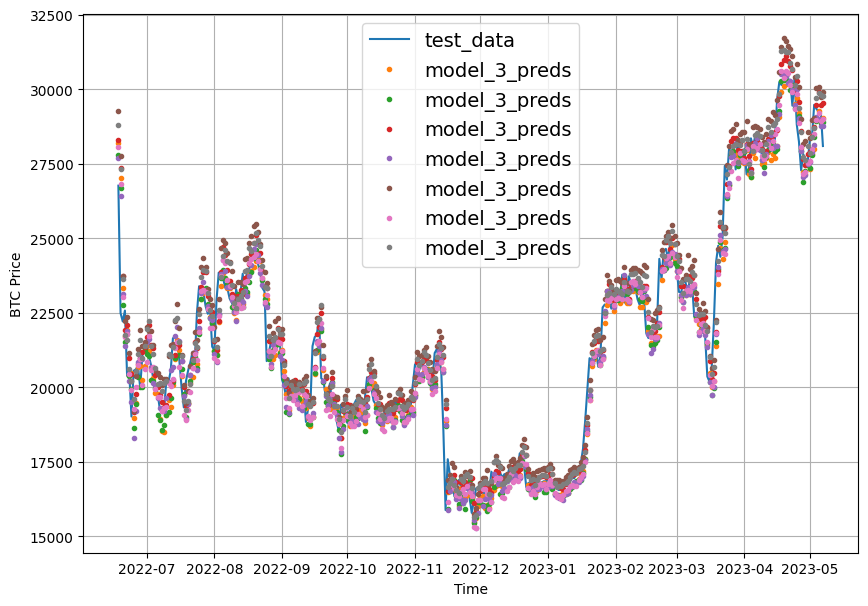

In [75]:
# Plot the model_3_preds
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_3_preds,
                 start=offset,
                 label='model_3_preds')

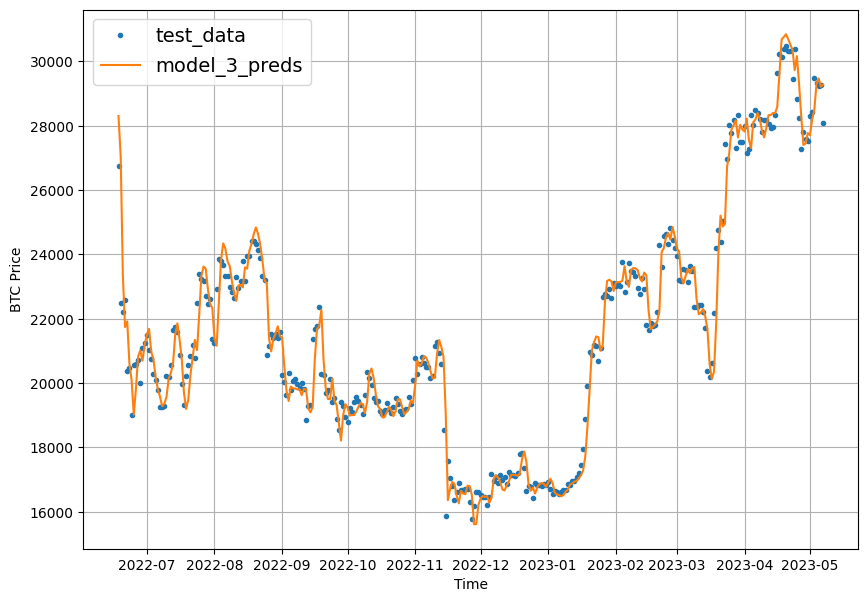

In [76]:
# Plot the model_3_preds - AGGREGATED VERSION 
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label='model_3_preds')

## Which of our models performs the best so far?

<Axes: >

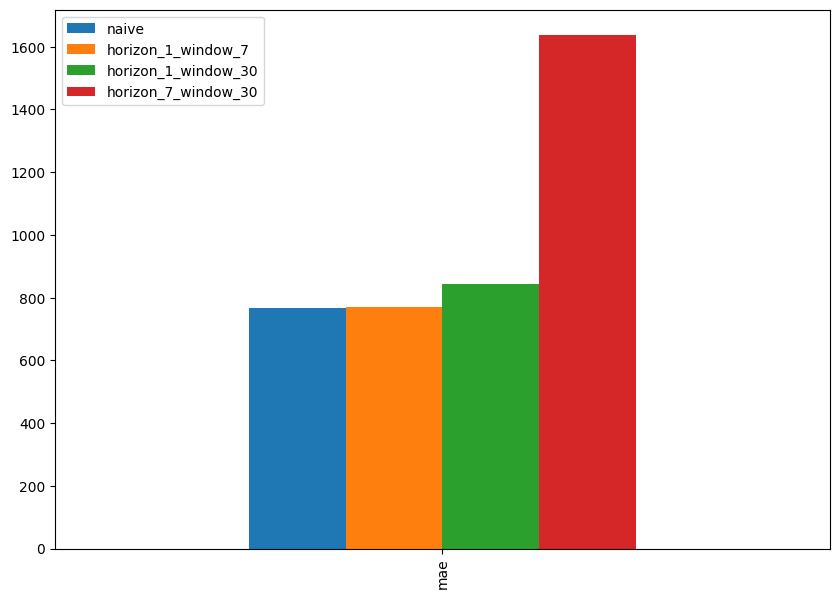

In [77]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']},
             index=['mae']).plot(figsize=(10,7), kind='bar')

## Model 4: Conv1D

In [78]:
HORIZON = 1 # predict next day...
WINDOW_SIZE = 7 # ...based on the week before

In [79]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3148, 3148)

In [80]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                               full_labels,
                                                                               test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

To use a Conv1D input layer, we need an input shape of `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet.

In [81]:
# Check data input shape
train_windows[0].shape

(7,)

In [82]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

In [83]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input_dim

In [84]:
# Test out the Lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}") # WINDOWS_SIZE, INPUT_DIM
print(f"Original values with expanded shape: {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


In [85]:
# Create the Conv1D model
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128,
                  kernel_size=5,
                  strides=1,
                  padding='causal',
                  activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# Compile a model
model_4.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_4.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])


Epoch 1: val_loss improved from inf to 4179.23096, saving model to model_experiments/model_4_conv1D



Epoch 2: val_loss improved from 4179.23096 to 1449.28320, saving model to model_experiments/model_4_conv1D



Epoch 3: val_loss did not improve from 1449.28320

Epoch 4: val_loss did not improve from 1449.28320

Epoch 5: val_loss improved from 1449.28320 to 1391.65759, saving model to model_experiments/model_4_conv1D



Epoch 6: val_loss improved from 1391.65759 to 1340.10730, saving model to model_experiments/model_4_conv1D



Epoch 7: val_loss improved from 1340.10730 to 1293.34106, saving model to model_experiments/model_4_conv1D



Epoch 8: val_loss did not improve from 1293.34106

Epoch 9: val_loss did not improve from 1293.34106

Epoch 10: val_loss improved from 1293.34106 to 1257.44409, saving model to model_experiments/model_4_conv1D



Epoch 11: val_loss improved from 1257.44409 to 1248.68860, saving model to model_experiments/model_4_conv1D



Epoch 12: val_loss did not improve from 1248.68860

Epoch 13: val_loss did not improve from 1248.68860

Epoch 14: val_loss did not improve from 1248.68860

Epoch 15: val_loss improved from 1248.68860 to 1180.17102, saving model to model_experiments/model_4_conv1D



Epoch 16: val_loss improved from 1180.17102 to 1173.14392, saving model to model_experiments/model_4_conv1D



Epoch 17: val_loss did not improve from 1173.14392

Epoch 18: val_loss did not improve from 1173.14392

Epoch 19: val_loss improved from 1173.14392 to 1147.63831, saving model to model_experiments/model_4_conv1D



Epoch 20: val_loss improved from 1147.63831 to 1116.78833, saving model to model_experiments/model_4_conv1D



Epoch 21: val_loss did not improve from 1116.78833

Epoch 22: val_loss did not improve from 1116.78833

Epoch 23: val_loss improved from 1116.78833 to 1080.06091, saving model to model_experiments/model_4_conv1D



Epoch 24: val_loss did not improve from 1080.06091

Epoch 25: val_loss improved from 1080.06091 to 1058.98071, saving model to model_experiments/model_4_conv1D



Epoch 26: val_loss improved from 1058.98071 to 1033.69751, saving model to model_experiments/model_4_conv1D



Epoch 27: val_loss improved from 1033.69751 to 1001.21051, saving model to model_experiments/model_4_conv1D



Epoch 28: val_loss did not improve from 1001.21051

Epoch 29: val_loss did not improve from 1001.21051

Epoch 30: val_loss improved from 1001.21051 to 969.85052, saving model to model_experiments/model_4_conv1D



Epoch 31: val_loss improved from 969.85052 to 959.61505, saving model to model_experiments/model_4_conv1D



Epoch 32: val_loss did not improve from 959.61505

Epoch 33: val_loss did not improve from 959.61505

Epoch 34: val_loss improved from 959.61505 to 936.32629, saving model to model_experiments/model_4_conv1D



Epoch 35: val_loss did not improve from 936.32629

Epoch 36: val_loss did not improve from 936.32629

Epoch 37: val_loss improved from 936.32629 to 903.39502, saving model to model_experiments/model_4_conv1D



Epoch 38: val_loss did not improve from 903.39502

Epoch 39: val_loss did not improve from 903.39502

Epoch 40: val_loss improved from 903.39502 to 884.97144, saving model to model_experiments/model_4_conv1D



Epoch 41: val_loss improved from 884.97144 to 882.76935, saving model to model_experiments/model_4_conv1D



Epoch 42: val_loss did not improve from 882.76935

Epoch 43: val_loss improved from 882.76935 to 877.17181, saving model to model_experiments/model_4_conv1D



Epoch 44: val_loss did not improve from 877.17181

Epoch 45: val_loss did not improve from 877.17181

Epoch 46: val_loss did not improve from 877.17181

Epoch 47: val_loss did not improve from 877.17181

Epoch 48: val_loss did not improve from 877.17181

Epoch 49: val_loss did not improve from 877.17181

Epoch 50: val_loss improved from 877.17181 to 856.27826, saving model to model_experiments/model_4_conv1D



Epoch 51: val_loss improved from 856.27826 to 853.17810, saving model to model_experiments/model_4_conv1D



Epoch 52: val_loss improved from 853.17810 to 852.01678, saving model to model_experiments/model_4_conv1D



Epoch 53: val_loss did not improve from 852.01678

Epoch 54: val_loss improved from 852.01678 to 851.52936, saving model to model_experiments/model_4_conv1D



Epoch 55: val_loss did not improve from 851.52936

Epoch 56: val_loss did not improve from 851.52936

Epoch 57: val_loss did not improve from 851.52936

Epoch 58: val_loss did not improve from 851.52936

Epoch 59: val_loss did not improve from 851.52936

Epoch 60: val_loss improved from 851.52936 to 840.31897, saving model to model_experiments/model_4_conv1D



Epoch 61: val_loss did not improve from 840.31897

Epoch 62: val_loss did not improve from 840.31897

Epoch 63: val_loss did not improve from 840.31897

Epoch 64: val_loss did not improve from 840.31897

Epoch 65: val_loss improved from 840.31897 to 838.12036, saving model to model_experiments/model_4_conv1D



Epoch 66: val_loss did not improve from 838.12036

Epoch 67: val_loss did not improve from 838.12036

Epoch 68: val_loss improved from 838.12036 to 825.59174, saving model to model_experiments/model_4_conv1D



Epoch 69: val_loss did not improve from 825.59174

Epoch 70: val_loss did not improve from 825.59174

Epoch 71: val_loss improved from 825.59174 to 821.58191, saving model to model_experiments/model_4_conv1D



Epoch 72: val_loss did not improve from 821.58191

Epoch 73: val_loss did not improve from 821.58191

Epoch 74: val_loss did not improve from 821.58191

Epoch 75: val_loss did not improve from 821.58191

Epoch 76: val_loss did not improve from 821.58191

Epoch 77: val_loss improved from 821.58191 to 819.00555, saving model to model_experiments/model_4_conv1D



Epoch 78: val_loss did not improve from 819.00555

Epoch 79: val_loss improved from 819.00555 to 811.79901, saving model to model_experiments/model_4_conv1D



Epoch 80: val_loss did not improve from 811.79901

Epoch 81: val_loss improved from 811.79901 to 809.51703, saving model to model_experiments/model_4_conv1D



Epoch 82: val_loss did not improve from 809.51703

Epoch 83: val_loss did not improve from 809.51703

Epoch 84: val_loss did not improve from 809.51703

Epoch 85: val_loss did not improve from 809.51703

Epoch 86: val_loss did not improve from 809.51703

Epoch 87: val_loss did not improve from 809.51703

Epoch 88: val_loss did not improve from 809.51703

Epoch 89: val_loss did not improve from 809.51703

Epoch 90: val_loss did not improve from 809.51703

Epoch 91: val_loss improved from 809.51703 to 804.70935, saving model to model_experiments/model_4_conv1D



Epoch 92: val_loss did not improve from 804.70935

Epoch 93: val_loss did not improve from 804.70935

Epoch 94: val_loss did not improve from 804.70935

Epoch 95: val_loss did not improve from 804.70935

Epoch 96: val_loss did not improve from 804.70935

Epoch 97: val_loss did not improve from 804.70935

Epoch 98: val_loss did not improve from 804.70935

Epoch 99: val_loss improved from 804.70935 to 796.69806, saving model to model_experiments/model_4_conv1D



Epoch 100: val_loss did not improve from 796.69806


In [86]:
# Evaluate model_4
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 872.2673 - mae: 872.2673 - mse: 1669845.0000


[872.267333984375, 872.267333984375, 1669845.0]

In [87]:
# Load in the best performing model_4
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 796.6981 - mae: 796.6981 - mse: 1483295.3750


[796.6980590820312, 796.6980590820312, 1483295.375]

In [88]:
# Make predictions 
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47296.89 , 46402.78 , 45168.453, 44646.984, 46162.156, 48709.855,
       49202.258, 49662.918, 49852.6  , 48327.434], dtype=float32)>

In [89]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 796.69806,
 'mse': 1483295.5,
 'rmse': 1217.9061,
 'mape': 2.35048,
 'mase': 1.0381851}

In [90]:
model_1_results

{'mae': 771.5409,
 'mse': 1404546.1,
 'rmse': 1185.1355,
 'mape': 2.2753763,
 'mase': 1.0054026}

## Model 5: LSTM
Let's create a RNN model for our time series data.

We're going to use the same data we have created for previous experiment.

In [91]:
# Let's create LSTM model using Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
#x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_LSTM')

# Compile
model_5.compile(loss='mae',
                optimizer='adam')
                #metrics=['mae', 'mse'])

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
11/20 [===============>..............] - ETA: 0s - loss: 7354.8599 
Epoch 1: val_loss improved from inf to 17592.06250, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 5s 147ms/step - loss: 6473.1870 - val_loss: 17592.0625
Epoch 2/100
18/20 [==========================>...] - ETA: 0s - loss: 2822.4329
Epoch 2: val_loss improved from 17592.06250 to 1490.80969, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 116ms/step - loss: 2632.9927 - val_loss: 1490.8097
Epoch 3/100
11/20 [===============>..............] - ETA: 0s - loss: 748.4405
Epoch 3: val_loss improved from 1490.80969 to 1489.88635, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 116ms/step - loss: 635.9744 - val_loss: 1489.8864
Epoch 4/100
11/20 [===============>..............] - ETA: 0s - loss: 504.1089
Epoch 4: val_loss did not improve from 1489.88635
20/20 [==============================] -

In [92]:
# Load in the best version of model_5 and evaluate
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 852.5438


852.5438232421875

In [93]:
# Make prediction 
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

20/20 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47148.86 , 46700.684, 45396.71 , 44903.223, 45707.105],
      dtype=float32)>

In [94]:
# Evaluate model_5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 852.54407,
 'mse': 1626600.9,
 'rmse': 1275.3826,
 'mape': 2.5170872,
 'mase': 1.1109586}

In [95]:
model_1_results

{'mae': 771.5409,
 'mse': 1404546.1,
 'rmse': 1185.1355,
 'mape': 2.2753763,
 'mase': 1.0054026}

## Make a multivariate time series data

Before we add feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...
* day 1 - 0
* day 2 - 1
* day 3 - 0 and so on

What's a better feature to use?

Maybe Bitcon halving events?

In [96]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [97]:
# Let's add Bitcoin halving events to our data
block_reward_1 = 50 # 3 Jan 2009 - this reward isn't in our dataset (start from 17/9/2014)
block_reward_2 = 25 # 28 Nov 2012 - this reward isn't in our dataset, too
block_reward_3 = 12.5 # 9 Jul 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [98]:
# Create date ranges where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2070)

In [99]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add in block_reward values as a feature to our dataframes
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-05-03,29006.308594,6.25
2023-05-04,28847.710938,6.25
2023-05-05,29534.384766,6.25
2023-05-06,28904.623047,6.25
2023-05-07,28897.636719,6.25


<Axes: xlabel='Date'>

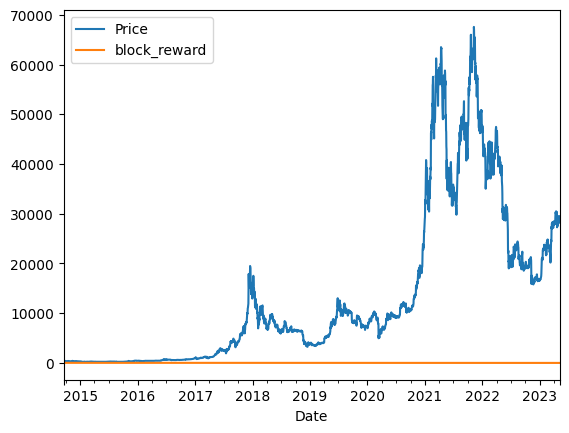

In [100]:
bitcoin_prices_block.plot()

<Axes: xlabel='Date'>

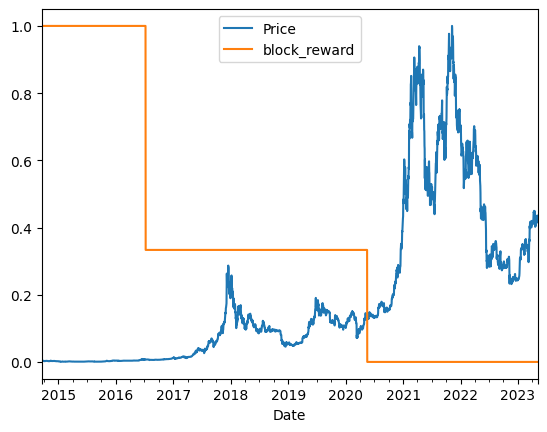

In [101]:
# Plot the block_reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot()

## Making a windowed dataset with `Pandas`
Previously we've turned our univariate time series into windowed dataset using helper functions above.

However, since we'ge got multivariate now, these functions won't work.

Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data. 

In [102]:
# Setup hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [103]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in window size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


What we've done is create a way to window our dataset directly from a `pandas.DataFrame`.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
...
```

In [104]:
# Create X (windows) and y (horizon) features
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head(), y.head()

(            block_reward     Price+1     Price+2     Price+3     Price+4  \
 Date                                                                       
 2014-09-24          25.0  435.790985  402.152008  398.821014  408.903992   
 2014-09-25          25.0  423.204987  435.790985  402.152008  398.821014   
 2014-09-26          25.0  411.574005  423.204987  435.790985  402.152008   
 2014-09-27          25.0  404.424988  411.574005  423.204987  435.790985   
 2014-09-28          25.0  399.519989  404.424988  411.574005  423.204987   
 
                Price+5     Price+6     Price+7  
 Date                                            
 2014-09-24  394.795990  424.440002  457.334015  
 2014-09-25  408.903992  394.795990  424.440002  
 2014-09-26  398.821014  408.903992  394.795990  
 2014-09-27  402.152008  398.821014  408.903992  
 2014-09-28  435.790985  402.152008  398.821014  ,
 Date
 2014-09-24    423.204987
 2014-09-25    411.574005
 2014-09-26    404.424988
 2014-09-27    399.51998

In [105]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

In [106]:
X_train

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.00,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.00,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.00,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.00,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.00,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2021-08-11,6.25,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688,39747.503906
2021-08-12,6.25,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688
2021-08-13,6.25,44428.289062,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000


## Model 6: Dense (but on multivariate data)

In [107]:
tf.random.set_seed(42)

# Make a multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

# Compile the model
model_6.compile(loss='mae',
                optimizer='adam')

# Fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
14/20 [====================>.........] - ETA: 0s - loss: 2979.0745 
Epoch 1: val_loss improved from inf to 2755.37695, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 3s 58ms/step - loss: 2334.2727 - val_loss: 2755.3770
Epoch 2/100
13/20 [==================>...........] - ETA: 0s - loss: 577.4554
Epoch 2: val_loss improved from 2755.37695 to 1606.66809, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 47ms/step - loss: 530.6645 - val_loss: 1606.6681
Epoch 3/100
15/20 [=====================>........] - ETA: 0s - loss: 433.1457
Epoch 3: val_loss improved from 1606.66809 to 1206.73352, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 47ms/step - loss: 423.2953 - val_loss: 1206.7335
Epoch 4/100
14/20 [====================>.........] - ETA: 0s - loss: 363.5246
Epoch 4: val_loss improved from 1206.73352 to 1053.78198, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 36ms/step - loss: 373.3554 - val_loss: 1053.7820
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 343.0953
Epoch 5: val_loss improved from 1053.78198 to 947.37958, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 32ms/step - loss: 343.0953 - val_loss: 947.3796
Epoch 6/100
18/20 [==========================>...] - ETA: 0s - loss: 303.2765
Epoch 6: val_loss improved from 947.37958 to 935.82690, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 32ms/step - loss: 311.6969 - val_loss: 935.8269
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 318.3811
Epoch 7: val_loss improved from 935.82690 to 929.23425, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 52ms/step - loss: 318.3811 - val_loss: 929.2343
Epoch 8/100
20/20 [==============================] - ETA: 0s - loss: 336.1185
Epoch 8: val_loss improved from 929.23425 to 922.21332, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 336.1185 - val_loss: 922.2133
Epoch 9/100
18/20 [==========================>...] - ETA: 0s - loss: 318.0791
Epoch 9: val_loss improved from 922.21332 to 862.47949, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 32ms/step - loss: 313.6854 - val_loss: 862.4795
Epoch 10/100
20/20 [==============================] - ETA: 0s - loss: 320.6447
Epoch 10: val_loss did not improve from 862.47949
20/20 [==============================] - 0s 5ms/step - loss: 320.6447 - val_loss: 901.6385
Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 311.6448
Epoch 11: val_loss improved from 862.47949 to 850.03217, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 37ms/step - loss: 311.6448 - val_loss: 850.0322
Epoch 12/100
15/20 [=====================>........] - ETA: 0s - loss: 297.8355
Epoch 12: val_loss improved from 850.03217 to 841.53827, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 47ms/step - loss: 291.7694 - val_loss: 841.5383
Epoch 13/100
15/20 [=====================>........] - ETA: 0s - loss: 293.3091
Epoch 13: val_loss did not improve from 841.53827
20/20 [==============================] - 0s 7ms/step - loss: 292.6648 - val_loss: 1040.2140
Epoch 14/100
14/20 [====================>.........] - ETA: 0s - loss: 288.7860
Epoch 14: val_loss did not improve from 841.53827
20/20 [==============================] - 0s 7ms/step - loss: 289.0285 - val_loss: 1168.0374
Epoch 15/100
14/20 [====================>.........] - ETA: 0s - loss: 344.0051
Epoch 15: val_loss did not improve from 841.53827
20/20 [==============================] - 0s 7ms/step - loss: 353.4670 - val_loss: 855.2842
Epoch 16/100
14/20 [====================>.........] - ETA: 0s - loss: 326.5951
Epoch 16: val_loss did not improve from 841.53827
20/20 [==============================] - 0s 7ms/step - loss: 316.9250 - val_loss: 928.8458
Epoch 17/100
15/20 [======

20/20 [==============================] - 1s 52ms/step - loss: 340.2200 - val_loss: 806.5447
Epoch 22/100
17/20 [========================>.....] - ETA: 0s - loss: 266.4414
Epoch 22: val_loss did not improve from 806.54474
20/20 [==============================] - 0s 15ms/step - loss: 274.4437 - val_loss: 866.2605
Epoch 23/100
16/20 [=======================>......] - ETA: 0s - loss: 308.7609
Epoch 23: val_loss did not improve from 806.54474
20/20 [==============================] - 0s 18ms/step - loss: 313.7640 - val_loss: 852.1372
Epoch 24/100
18/20 [==========================>...] - ETA: 0s - loss: 362.6036
Epoch 24: val_loss did not improve from 806.54474
20/20 [==============================] - 0s 14ms/step - loss: 364.5226 - val_loss: 1122.1265
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 330.1350
Epoch 25: val_loss did not improve from 806.54474
20/20 [==============================] - 0s 12ms/step - loss: 330.1350 - val_loss: 1066.3615
Epoch 26/100
16/20 [==

20/20 [==============================] - 2s 104ms/step - loss: 270.1605 - val_loss: 798.1402
Epoch 33/100
17/20 [========================>.....] - ETA: 0s - loss: 274.3682
Epoch 33: val_loss did not improve from 798.14020
20/20 [==============================] - 0s 9ms/step - loss: 281.7684 - val_loss: 814.8915
Epoch 34/100
19/20 [===========================>..] - ETA: 0s - loss: 271.2068
Epoch 34: val_loss did not improve from 798.14020
20/20 [==============================] - 0s 5ms/step - loss: 273.5602 - val_loss: 841.1136
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 267.0099
Epoch 35: val_loss did not improve from 798.14020
20/20 [==============================] - 0s 6ms/step - loss: 267.0099 - val_loss: 813.8337
Epoch 36/100
10/20 [==============>...............] - ETA: 0s - loss: 278.2791
Epoch 36: val_loss improved from 798.14020 to 797.62677, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 49ms/step - loss: 269.7269 - val_loss: 797.6268
Epoch 37/100
19/20 [===========================>..] - ETA: 0s - loss: 283.1464
Epoch 37: val_loss did not improve from 797.62677
20/20 [==============================] - 0s 11ms/step - loss: 281.7493 - val_loss: 923.7115
Epoch 38/100
16/20 [=======================>......] - ETA: 0s - loss: 282.4677
Epoch 38: val_loss did not improve from 797.62677
20/20 [==============================] - 0s 6ms/step - loss: 296.5512 - val_loss: 1054.5980
Epoch 39/100
 9/20 [============>.................] - ETA: 0s - loss: 280.3503
Epoch 39: val_loss did not improve from 797.62677
20/20 [==============================] - 0s 12ms/step - loss: 275.4143 - val_loss: 810.4026
Epoch 40/100
11/20 [===============>..............] - ETA: 0s - loss: 277.1053
Epoch 40: val_loss did not improve from 797.62677
20/20 [==============================] - 0s 12ms/step - loss: 284.0117 - val_loss: 891.5836
Epoch 41/100
18/20 [====

20/20 [==============================] - 1s 52ms/step - loss: 280.3342 - val_loss: 789.3776
Epoch 50/100
16/20 [=======================>......] - ETA: 0s - loss: 253.8910
Epoch 50: val_loss did not improve from 789.37762
20/20 [==============================] - 0s 5ms/step - loss: 262.8586 - val_loss: 827.6665
Epoch 51/100
20/20 [==============================] - ETA: 0s - loss: 267.0518
Epoch 51: val_loss improved from 789.37762 to 789.26489, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 4s 191ms/step - loss: 267.0518 - val_loss: 789.2649
Epoch 52/100
14/20 [====================>.........] - ETA: 0s - loss: 268.5923
Epoch 52: val_loss did not improve from 789.26489
20/20 [==============================] - 0s 7ms/step - loss: 276.1654 - val_loss: 1002.2014
Epoch 53/100
15/20 [=====================>........] - ETA: 0s - loss: 296.8633
Epoch 53: val_loss did not improve from 789.26489
20/20 [==============================] - 0s 9ms/step - loss: 293.0469 - val_loss: 911.5871
Epoch 54/100
18/20 [==========================>...] - ETA: 0s - loss: 285.7588
Epoch 54: val_loss did not improve from 789.26489
20/20 [==============================] - 0s 12ms/step - loss: 283.3466 - val_loss: 815.7032
Epoch 55/100
14/20 [====================>.........] - ETA: 0s - loss: 286.3268
Epoch 55: val_loss did not improve from 789.26489
20/20 [==============================] - 0s 7ms/step - loss: 282.2991 - val_loss: 903.5057
Epoch 56/100
18/20 [=====

20/20 [==============================] - 1s 55ms/step - loss: 302.2546 - val_loss: 779.4326
Epoch 57/100
12/20 [=================>............] - ETA: 0s - loss: 272.7109
Epoch 57: val_loss did not improve from 779.43262
20/20 [==============================] - 0s 11ms/step - loss: 263.5291 - val_loss: 798.2526
Epoch 58/100
19/20 [===========================>..] - ETA: 0s - loss: 279.5258
Epoch 58: val_loss did not improve from 779.43262
20/20 [==============================] - 0s 9ms/step - loss: 278.8330 - val_loss: 835.0065
Epoch 59/100
12/20 [=================>............] - ETA: 0s - loss: 270.9538
Epoch 59: val_loss did not improve from 779.43262
20/20 [==============================] - 0s 8ms/step - loss: 267.1891 - val_loss: 882.4737
Epoch 60/100
19/20 [===========================>..] - ETA: 0s - loss: 269.6735
Epoch 60: val_loss did not improve from 779.43262
20/20 [==============================] - 0s 9ms/step - loss: 267.8706 - val_loss: 788.1842
Epoch 61/100
18/20 [=======

20/20 [==============================] - 1s 39ms/step - loss: 266.2537 - val_loss: 775.4124
Epoch 70/100
20/20 [==============================] - ETA: 0s - loss: 370.6271
Epoch 70: val_loss did not improve from 775.41235
20/20 [==============================] - 0s 4ms/step - loss: 370.6271 - val_loss: 1183.2111
Epoch 71/100
12/20 [=================>............] - ETA: 0s - loss: 360.8657
Epoch 71: val_loss did not improve from 775.41235
20/20 [==============================] - 0s 6ms/step - loss: 353.2682 - val_loss: 1048.7588
Epoch 72/100
17/20 [========================>.....] - ETA: 0s - loss: 304.0009
Epoch 72: val_loss did not improve from 775.41235
20/20 [==============================] - 0s 5ms/step - loss: 302.2975 - val_loss: 794.2542
Epoch 73/100
19/20 [===========================>..] - ETA: 0s - loss: 288.5665
Epoch 73: val_loss did not improve from 775.41235
20/20 [==============================] - 0s 9ms/step - loss: 285.2480 - val_loss: 785.1841
Epoch 74/100
20/20 [======

In [108]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 5ms/step - loss: 799.2610


799.260986328125

In [109]:
# Load best performing model
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 775.4124


775.412353515625

In [110]:
# Make predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47083.934, 46020.28 , 44714.746, 44699.207, 46318.746, 49032.36 ,
       49117.902, 49337.12 , 49467.582, 47936.56 ], dtype=float32)>

In [111]:
# Evaluate predictions to get metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 775.4123,
 'mse': 1425506.9,
 'rmse': 1193.9459,
 'mape': 2.282825,
 'mase': 1.0104474}

In [112]:
model_1_results

{'mae': 771.5409,
 'mse': 1404546.1,
 'rmse': 1185.1355,
 'mape': 2.2753763,
 'mase': 1.0054026}

In [113]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

## Model 7: N-BEATS algorithm
Let's now try andbuild the biggest, baddest time series forecasting model we've built so far.

More specifically, we'll be replicating the algo from the paper's figure 1:
https://arxiv.org/pdf/1905.10437.pdf

Why?
* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow subclassing to make our own custom layers
* We will get experiance using the Functional API to create custom architecture
* Potintially get state-of-the-art results and beat the Naive forecast 

### Building and testing the N-BEATS block layer

Because N-BEATS block layer does not exist in TensorFlow, we need to create it.

To create custom layers and models, we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [114]:
# Create N-BEATS block custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__ (self, 
                input_size: int,
                theta_size: int,
                horizon: int,
                n_neurons: int,
                n_layers: int,
                **kwargs): # the keyword args argument takces care of all the parent args (input_size etc.)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 FC layers, each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs): # 'call' function is obligatory when inhereting from Layer class
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)

    # Output - backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

LEt's test our N-BEATS block class. To do so, we'll make some dummy inputs and outputs.

In [115]:
# Setup dummy N-BEATS block layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast and forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [118]:
# Create dummy inputs (have to be the same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE + 1), axis=0) # input shape has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [120]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are going to be activation outputs of the theta layer (random due to no training)
print(f"Backcast: \n{tf.squeeze(backcast).numpy()},\n\nForecast:\n {tf.squeeze(forecast).numpy()}")

Backcast: 
[ 0.7069396  -0.17615238  0.49925137 -0.24880263  0.00116318 -0.183703
 -0.05882841],

Forecast:
 -0.576218843460083
